In [1]:
import math
import numpy as np
import torch
from load_data import load_data, uniform_metric_distribution
from model import ElectronOpticsPredictor
from utils import plot_inference_comparison

In [2]:
solid_angle_scaling = math.sin(math.radians(5 / 2)) / math.sin(math.radians(60 / 2))
APER_0_D = 0.5
DET_D = 25


def angle_resolved_aper0(aper0_map: np.ndarray) -> np.ndarray:
    aberrations = (
        aper0_map[:, 0] ** 2
        + aper0_map[:, 2] ** 2
        + (aper0_map[:, 3] * solid_angle_scaling) ** 2
        + (aper0_map[:, 4] * (solid_angle_scaling**2)) ** 2
        + (aper0_map[:, 5] * (solid_angle_scaling**3)) ** 2
    )
    return (
        aberrations
        + (np.abs(aper0_map[:, 1] * solid_angle_scaling) - APER_0_D / 2) ** 2
    )


def spatial_resolved_detector(detector_map: np.ndarray) -> np.ndarray:
    aberrations = (
        (detector_map[:, 1] * solid_angle_scaling) ** 2
        + detector_map[:, 2] ** 2
        + (detector_map[:, 3] * solid_angle_scaling) ** 2
        + (detector_map[:, 4] * (solid_angle_scaling**2)) ** 2
        + (detector_map[:, 5] * (solid_angle_scaling**3)) ** 2
    )
    return aberrations + (np.abs(detector_map[:, 0]) - DET_D / 2) ** 2


def metric(output: np.ndarray) -> np.ndarray:
    if isinstance(output, torch.Tensor):
        return objective(output)
    return angle_resolved_aper0(output[:, :6]) * 1000 + spatial_resolved_detector(
        output[:, 6:]
    )


def objective(output: torch.Tensor, device: torch.device = None):
    device = torch.device("cpu") if device is None else device
    output.to(device)

    angle_scaling = 1000

    angle_aberrations = (
        output[0] ** 2
        + output[2] ** 2
        + (output[3] * solid_angle_scaling) ** 2
        + (output[4] * (solid_angle_scaling**2)) ** 2
        + (output[5] * (solid_angle_scaling**3)) ** 2
    )
    spatial_aberrations = (
        (output[1 + 6] * solid_angle_scaling) ** 2
        + output[2 + 6] ** 2
        + (output[3 + 6] * solid_angle_scaling) ** 2
        + (output[4 + 6] * (solid_angle_scaling**2)) ** 2
        + (output[5 + 6] * (solid_angle_scaling**3)) ** 2
    )
    return (
        (torch.abs(output[1]) * solid_angle_scaling - APER_0_D / 2) ** 2 * angle_scaling
        + (torch.abs(output[6]) - DET_D / 2) ** 2
        + angle_aberrations * angle_scaling
        + spatial_aberrations
    )

In [4]:
raw_voltages, raw_outputs = load_data("parallel_test_model_data.csv")
voltages, outputs = uniform_metric_distribution(raw_voltages, raw_outputs, metric)

Using device: cpu
Epoch 0: Train Loss = 0.688994, Val Loss = 0.471129
Training completed. Best validation loss: 0.002521


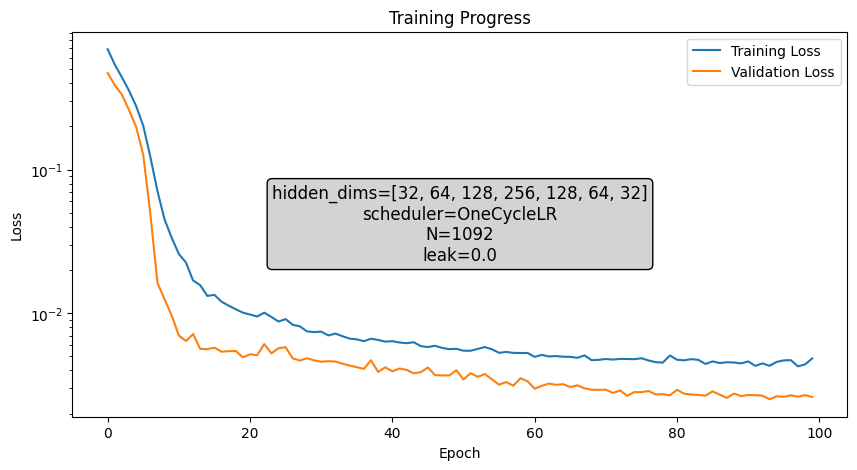

In [ ]:
predictor = ElectronOpticsPredictor(
    input_dim=voltages.shape[1], output_dim=outputs.shape[1]
)
predictor.train(voltages, outputs, epochs=100)
predictor.save_model("test_pred")

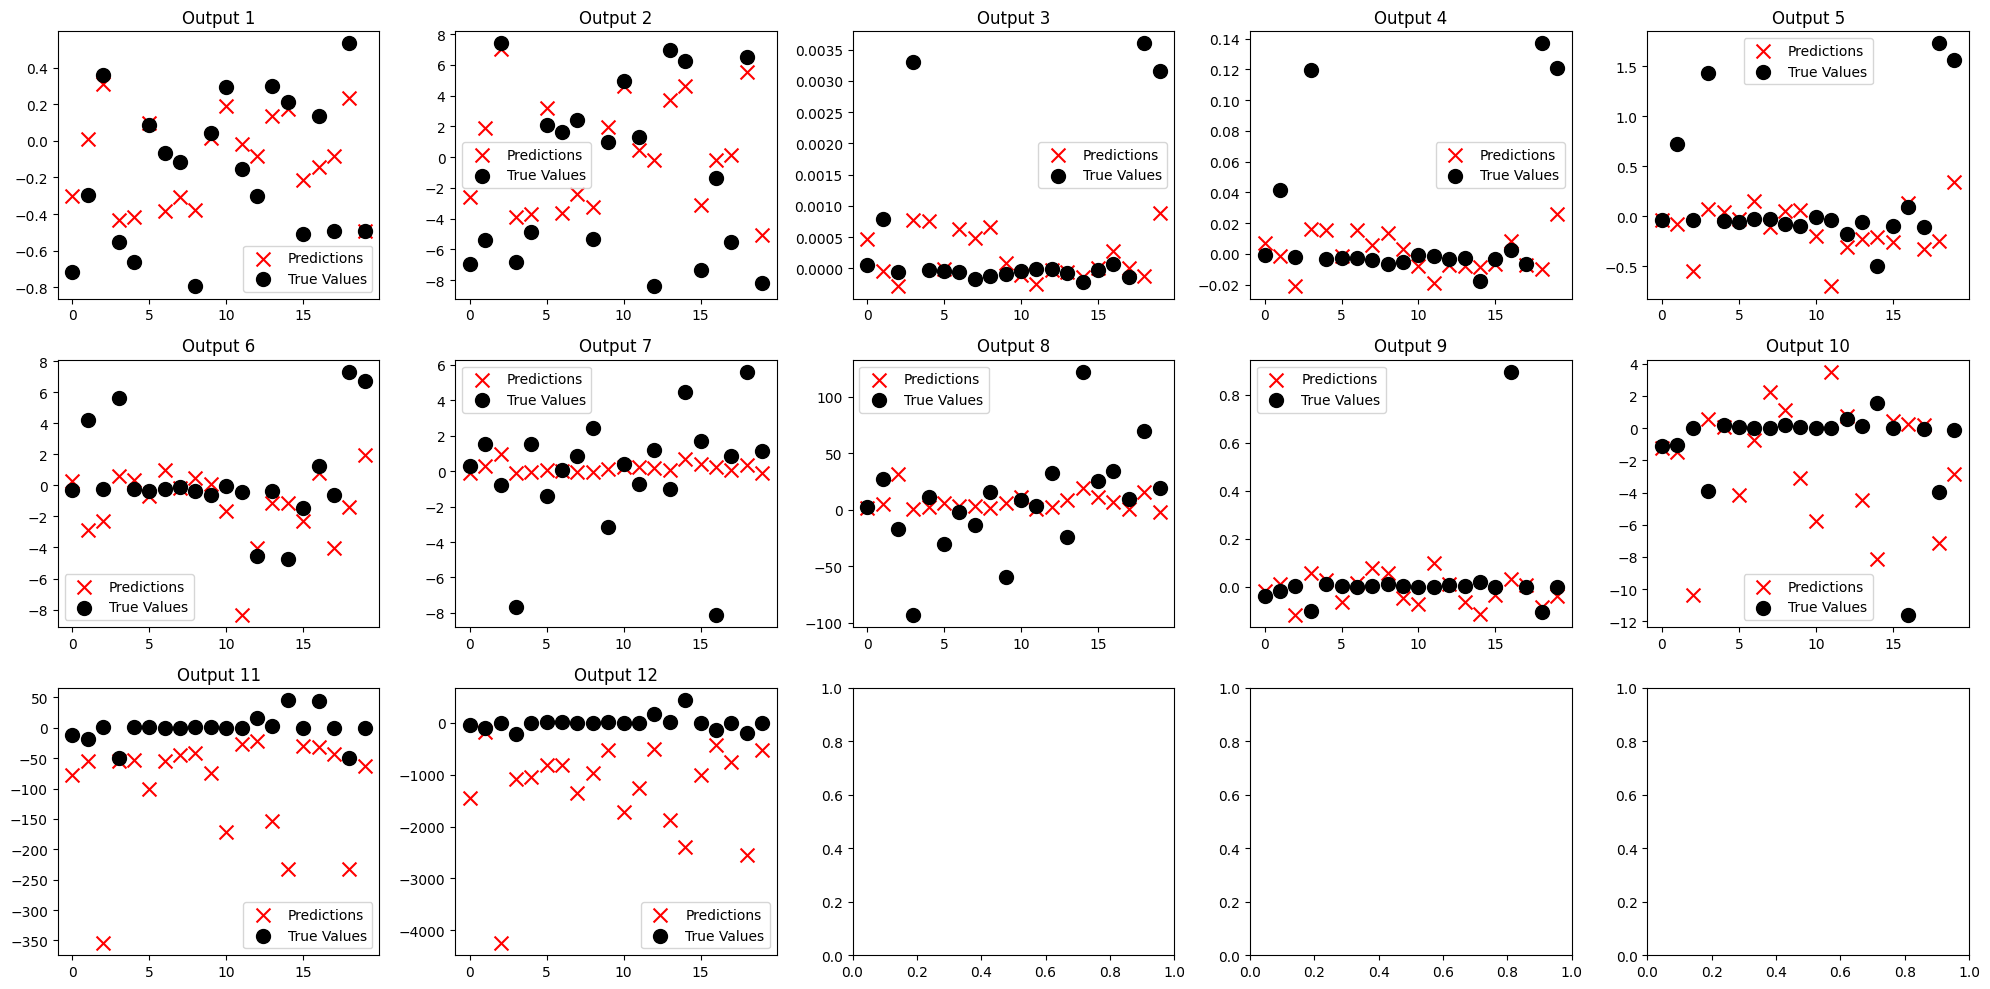

In [46]:
_ = plot_inference_comparison(predictor, n_samples=20)

In [5]:
predictor = ElectronOpticsPredictor.load_model("test_pred")

Using device: cpu


In [ ]:
predictor.optimize_voltages(
    metric, n_iterations=50000, random_restarts=10, constrain_to_training_range=True
)